## Problema 5: Rutas optimas para equipos de inspeccion de infraestructura en Colombia

### Preprocesamiento de datos

In [17]:
import numpy as np
import csv

def read_cost_matrix_csv(filename):
    """
    Lee una matriz de costos desde un archivo CSV y la devuelve como un array de numpy.
    Se asume que la primera fila contiene los IDs de las localidades.

    Parámetros:
        filename (str): Nombre del archivo CSV de entrada.

    Devuelve:
        numpy.ndarray: La matriz de costos leída desde el archivo.
    """
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        node_ids = next(reader)  # Lee los IDs de las localidades (no usado en este caso)
        data = list(reader)  # Lee los datos restantes

    # Convierte los datos a un array de numpy de enteros
    cost_matrix = np.array(data, dtype=int)

    return cost_matrix

def validate_cost_matrix(cost_matrix):
    """Verifica que la matriz de costos no tenga valores negativos o NaN."""
    if np.any(cost_matrix < 0):
        print("Error: La matriz de costos contiene valores negativos.")
        return False
    if np.any(np.isnan(cost_matrix)):
        print("Error: La matriz de costos contiene valores NaN.")
        return False
    return True

# Leer y validar la matriz de costos
filename = './matrix_cost/cost_matrix_5_nodes_2.5_spread.csv'  # Ajusta el nombre del archivo según tu caso
cost_matrix = read_cost_matrix_csv(filename)

# Verificar la validez de la matriz
if validate_cost_matrix(cost_matrix):
    print("La matriz de costos es válida.")
else:
    print("La matriz de costos no es válida.")

La matriz de costos es válida.


### Formulacion para un unico viajero

#### Conjuntos

Nodos: 
$$ N = \{N1,N_2,...,N_n\}$$
$$ \forall i \in N$$
$$ \forall j \in N$$

#### Parametros

Costos: De ir de i a j
$$ c_{ij}: \forall i\in N, \forall j\in N$$

#### Variables de decision

Tomar el camino de i a j
$$ x_{ij} \in {0,1}$$

Auxiliar para subtours
$$ u_{i} \leq n-1$$


#### Funcion objetivo

$$ MIN(\sum_{i\in N} \sum_{j\in N} x_{ij} \cdot c_{ij})$$

Costo total del viaje (se minimiza)

#### Restricciones

Cada localidad tiene una entrada

$$ \sum_{i\in D, i \neq j} x_{ij} = 1  , \forall j \in N$$

Cada localidad tiene una salida

$$ \sum_{j\in O, i \neq j} x_{ij} = 1 , \forall i \in N$$

No tener autociclos

$$ x_{i,i} = 0, \forall i \in N $$

$$ u_{i} \geq 0$$

Subtours

$$ u_i - u_j + n \cdot x_{ij} \leq n - 1, \forall i, j / i \neq j, i \neq 1, j \neq 1 \in N $$



In [18]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

class Optimization:
    def __init__(self, cost_matrix):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix)

    def build_model(self):
        # Crear el modelo
        self.model = pyo.ConcreteModel()

        # Conjuntos
        self.model.N = pyo.RangeSet(1, self.num_cities)

        # Variables de decisión: x[i, j] = 1 si viaja de i a j
        self.model.x = pyo.Var(self.model.N, self.model.N, within=pyo.Binary)

        # Variable auxiliar u[i] para eliminar subtours
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(1, self.num_cities - 1))

        # Parámetro de costos c[i, j]
        def cost_init(model, i, j):
            return self.cost_matrix[i - 1][j - 1]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Función objetivo: Minimizar el costo total
        def objective_function(model):
            return sum(model.x[i, j] * model.c[i, j]
                       for i in model.N for j in model.N)
        self.model.objective = pyo.Objective(rule=objective_function, sense=pyo.minimize)

        # Restricciones: cada ciudad tiene exactamente una salida
        def outbound_rule(model, i):
            return sum(model.x[i, j] for j in model.N if j != i) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=outbound_rule)

        # Restricciones: cada ciudad tiene exactamente una entrada
        def inbound_rule(model, j):
            return sum(model.x[i, j] for i in model.N if i != j) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=inbound_rule)

        # Restricción de no auto-ciclos
        def no_self_loops(model, i):
            return model.x[i, i] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=no_self_loops)

        # Restricciones de eliminación de subtours
        def subtour_elimination(model, i, j):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + self.num_cities * model.x[i, j] <= self.num_cities - 1
            else:
                return pyo.Constraint.Skip
        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, rule=subtour_elimination)


    def print_output(self):
        """
        Plots the solution as a directed graph using NetworkX and matplotlib.
        Since there's only one route (single driver), all edges are colored the same.
        """
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                if pyo.value(self.model.x[i, j]) > 0.5:
                    valid_edges.append((i, j))

        # Build a directed graph
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Add edges from the solution
        for (i, j) in valid_edges:
            G.add_edge(i, j)

        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos, with_labels=True,
                         node_color='lightblue',
                         edge_color='red',
                         arrows=True)
        plt.axis("off")
        plt.show()



In [19]:
# Crear el modelo
tsp = Optimization(cost_matrix)
tsp.build_model()


In [20]:
solver = pyo.SolverFactory('glpk')
r = solver.solve(tsp.model)


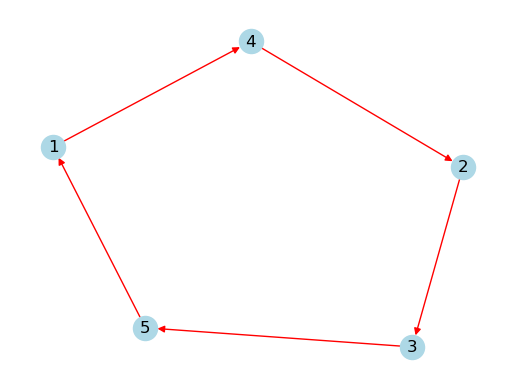


Problem: 
- Name: unknown
  Lower bound: 16.0
  Upper bound: 16.0
  Number of objectives: 1
  Number of constraints: 27
  Number of variables: 29
  Number of nonzeros: 81
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 9
      Number of created subproblems: 9
  Error rc: 0
  Time: 0.0081787109375
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [21]:
tsp.print_output()
print(r)


In [27]:
print(tsp.model.objective())

16.0


### Preguntas

- ¿Qué evidencia presenta el resultado obtenido? 
- ¿Es correcto el resultado de la implementación? 

- Es un camino ciclico que pasa por todos los nodos y el reporte final del solver indica óptimo = 16.0, lo que sugiere que sí encontró una solución factible y óptima.
- Esta bien, ya que usa la gran mayoria de de valores minimos de conexion, evitando los mas altos como el (6 y el 4) entre los nodos 5,4 y 3,4, asegurando asi, uno de los posibles caminos de costo minimo.


### Extension a multiples viajeros

#### Conjuntos

Nodos: 
$$ N = \{N1,N_2,...,N_n\}$$
$$ \forall i \in N$$
$$ \forall j \in N$$

#### Parametros

Costos: De ir de i a j
$$ c_{ij}: \forall i\in N, \forall j\in N$$

Numero de viajeros
$$ K $$

#### Variables de decision

Viajero k toma el camino de i a j
$$ x_{ijk} \in {0,1}$$

Auxiliar para subtours
$$ u_{i} \leq n-1$$


#### Funcion objetivo

$$ MIN(\sum_{i\in N} \sum_{j\in N} \sum_{k\in K} x_{ijk} \cdot c_{ij})$$

Costo total del viaje (se minimiza)

#### Restricciones

Cada localidad tiene una entrada

$$ \sum_{i\in D, i \neq j} \sum_{k\in K} x_{ijk} = 1  , \forall j \in N$$

Cada localidad tiene una salida

$$ \sum_{j\in O, i \neq j} \sum_{k\in K} x_{ijk} = 1 , \forall i \in N$$

No tener autociclos

$$ x_{i,i,k} = 0, \forall i \in N \forall k \in K $$

$$ u_{i} \geq 0$$

Subtours

$$ u_i - u_j + n \cdot x_{ijk} \leq n - 1, \forall i, j, k / i \neq j, i \neq 1, j \neq 1 \in N $$

Unicidad de localidad por equipo

$$ \sum_{K\in K} x_{ijk} = 1 , \forall j,i \in N / i \neq j$$



In [6]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


class Optimization2:
    """
    A TSP model for multiple drivers with a depot (city 0) and MTZ subtour elimination.
    """

    def __init__(self, cost_matrix, num_teams):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix)
        self.num_teams = num_teams

    def model(self):
        self.model = pyo.ConcreteModel()

        # Cities (including depot at 0)
        self.model.N = pyo.RangeSet(0, self.num_cities - 1)
        # Teams
        self.model.M = pyo.RangeSet(1, self.num_teams)

        # Variables: x[i,j,k] = 1 if team k travels from i to j
        self.model.x = pyo.Var(self.model.N, self.model.N, self.model.M, within=pyo.Binary)

        # MTZ auxiliary variables
        self.model.u = pyo.Var(self.model.N, self.model.M, within=pyo.NonNegativeReals, bounds=(1, self.num_cities - 1))

        # Cost parameter
        def cost_init(model, i, j):
            return self.cost_matrix[i][j]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Objective: Minimize total travel cost
        def obj_rule(model):
            return sum(model.x[i,j,k] * model.c[i,j] for i in model.N for j in model.N for k in model.M)
        self.model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Constraints
        def outbound_rule(model, i):
            if i != 0:
                return sum(model.x[i,j,k] for j in model.N for k in model.M if j != i) == 1
            else:
                return pyo.Constraint.Skip
        self.model.outbound = pyo.Constraint(self.model.N, rule=outbound_rule)

        def start_rule(model, k):
            return sum(model.x[0,j,k] for j in model.N if j != 0) == 1
        self.model.start = pyo.Constraint(self.model.M, rule=start_rule)

        def end_rule(model, k):
            return sum(model.x[i,0,k] for i in model.N if i != 0) == 1
        self.model.end = pyo.Constraint(self.model.M, rule=end_rule)

        def mid_rule(model, i, k):
            if i != 0:  # Excluir el nodo de inicio
                return sum(model.x[i, j, k] for j in model.N if j != i) == sum(model.x[j, i, k] for j in model.N if j != i)
            else:
                return pyo.Constraint.Skip

        self.model.mid = pyo.Constraint(self.model.N, self.model.M, rule=mid_rule)

        def mtz_rule(model, i, j, k):
            if i != j and i != 0 and j != 0:
                return model.u[i, k] - model.u[j, k] + (self.num_cities - 1) * model.x[i, j, k] <= self.num_cities - 2
            else:
                return pyo.Constraint.Skip
        self.model.mtz = pyo.Constraint(self.model.N, self.model.N, self.model.M, rule=mtz_rule)

        def no_self_loop_rule(model, i, k):
            return model.x[i,i,k] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, self.model.M, rule=no_self_loop_rule)

    def print_routes(self):
        print("Optimized Routes:")
        for k in self.model.M:
            route = []
            for i in self.model.N:
                for j in self.model.N:
                    if i != j and pyo.value(self.model.x[i, j, k]) == 1:
                        route.append((i, j))
            print(f"Team {k}: {route}")

    def solve_model(self):
        solver = pyo.SolverFactory('glpk')
        result = solver.solve(self.model)
        print(result)
        self.print_routes()

    def print_output(self):
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
        edge_colors = []
        edge_list = []

        # Inicializar un diccionario con colores por equipo
        team_labels = {k: colors[(k - 1) % len(colors)] for k in self.model.M}

        for k in self.model.M:
            for i in self.model.N:
                for j in self.model.N:
                    if i != j and pyo.value(self.model.x[i, j, k]) == 1:
                        G.add_edge(i, j)
                        edge_list.append((i, j))
                        edge_colors.append(colors[(k - 1) % len(colors)])

        pos = nx.circular_layout(G)

        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

        # Dibujar los arcos con los colores correctos
        nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color=edge_colors, width=2,
                                arrows=True, connectionstyle="arc3,rad=0.2")

        plt.title("Optimized Routes with Depot (0)")
        plt.axis('off')

        # Crear leyenda con los colores de los equipos
        legend_elements = [Line2D([0], [0], color=color, lw=2, label=f'Team {k}')
                          for k, color in team_labels.items()]

        plt.legend(handles=legend_elements, loc="upper left", title="Teams")

        plt.show()




### Casos


*** Procesando archivo: ./matrix_cost/cost_matrix_20_nodes_0.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 1 equipos...



Problem: 
- Name: unknown
  Lower bound: 6.0
  Upper bound: 6.0
  Number of objectives: 1
  Number of constraints: 402
  Number of variables: 419
  Number of nonzeros: 2167
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 40171
      Number of created subproblems: 40171
  Error rc: 0
  Time: 41.336418867111206
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 8), (1, 15), (2, 9), (3, 7), (4, 19), (5, 17), (6, 10), (7, 11), (8, 1), (9, 0), (10, 4), (11, 16), (12, 5), (13, 14), (14, 2), (15, 3), (16, 18), (17, 13), (18, 6), (19, 12)]


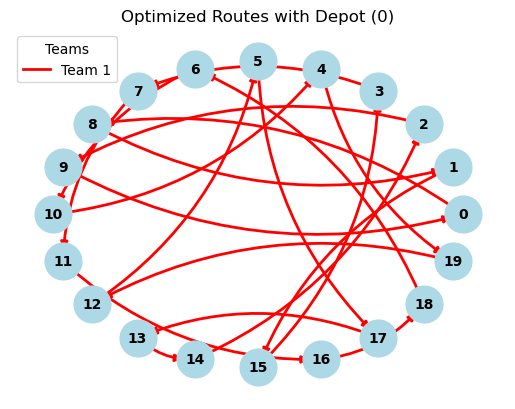


*** Procesando archivo: ./matrix_cost/cost_matrix_5_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 1 equipos...

Problem: 
- Name: unknown
  Lower bound: 16.0
  Upper bound: 16.0
  Number of objectives: 1
  Number of constraints: 27
  Number of variables: 29
  Number of nonzeros: 97
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 9
      Number of created subproblems: 9
  Error rc: 0
  Time: 0.004598140716552734
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 3), (1, 2), (2, 4), (3, 1), (4, 0)]


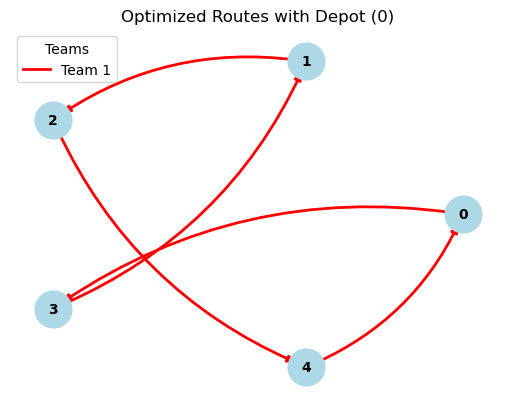


*** Procesando archivo: ./matrix_cost/cost_matrix_15_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 1 equipos...

Problem: 
- Name: unknown
  Lower bound: 37.0
  Upper bound: 37.0
  Number of objectives: 1
  Number of constraints: 227
  Number of variables: 239
  Number of nonzeros: 1177
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 119
      Number of created subproblems: 119
  Error rc: 0
  Time: 0.10238409042358398
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 6), (1, 11), (2, 4), (3, 14), (4, 12), (5, 2), (6, 8), (7, 9), (8, 5), (9, 10), (10, 1), (11, 0), (12, 3), (13, 7), (14, 13)]


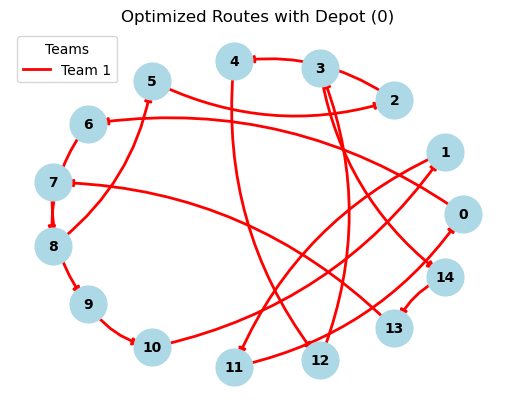


*** Procesando archivo: ./matrix_cost/cost_matrix_10_nodes_1.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 1 equipos...

Problem: 
- Name: unknown
  Lower bound: 15.0
  Upper bound: 15.0
  Number of objectives: 1
  Number of constraints: 102
  Number of variables: 109
  Number of nonzeros: 487
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 17
      Number of created subproblems: 17
  Error rc: 0
  Time: 0.008368492126464844
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 2), (1, 7), (2, 9), (3, 1), (4, 3), (5, 6), (6, 4), (7, 8), (8, 0), (9, 5)]


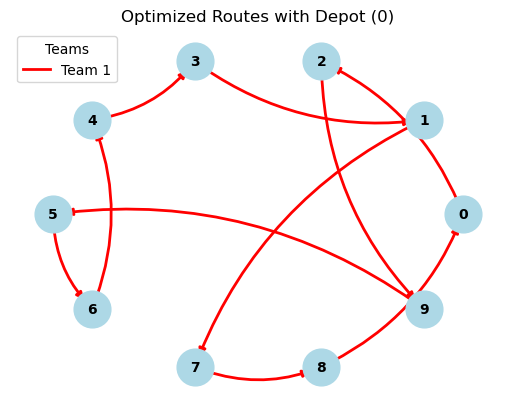

In [7]:
import glob
import os

def run_multi_tsp(folder_path, teams_list):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    for csv_file in csv_files:
        print(f"\n*** Procesando archivo: {csv_file} ***")
        cost_matrix = read_cost_matrix_csv(csv_file)
        if validate_cost_matrix(cost_matrix):
            print("La matriz de costos es válida.")
        else:
            print("La matriz de costos no es válida.")

        for teams in teams_list:
            print(f"--> Resolviendo con {teams} equipos...")
            tsp = Optimization2(cost_matrix, teams)
            tsp.model()
            tsp.solve_model()
            tsp.print_output()

if __name__ == "__main__":
    run_multi_tsp("./matrix_cost", [1])



*** Procesando archivo: ./matrix_cost/cost_matrix_20_nodes_0.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 2 equipos...

Problem: 
- Name: unknown
  Lower bound: 6.0
  Upper bound: 6.0
  Number of objectives: 1
  Number of constraints: 785
  Number of variables: 838
  Number of nonzeros: 4334
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 4049
      Number of created subproblems: 4049
  Error rc: 0
  Time: 6.464886426925659
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 9), (1, 15), (2, 14), (3, 7), (4, 10), (5, 12), (6, 16), (7, 1), (9, 2), (10, 6), (11, 3), (12, 19), (13, 17), (14, 13), (15, 0), (16, 18), (17, 5), (18, 11), (19, 4)]
Team 2: [(0, 8), (8, 0)]


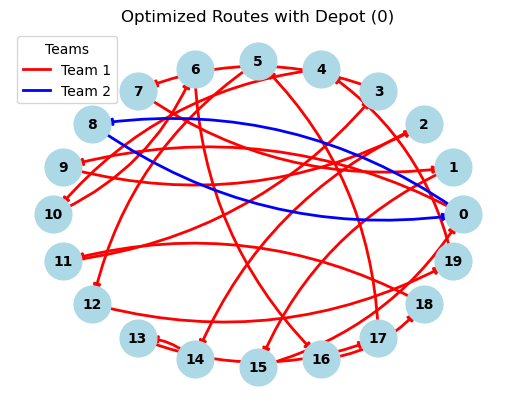


*** Procesando archivo: ./matrix_cost/cost_matrix_5_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 2 equipos...

Problem: 
- Name: unknown
  Lower bound: 18.0
  Upper bound: 18.0
  Number of objectives: 1
  Number of constraints: 50
  Number of variables: 58
  Number of nonzeros: 194
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 7
      Number of created subproblems: 7
  Error rc: 0
  Time: 0.006510257720947266
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 4), (4, 0)]
Team 2: [(0, 1), (1, 3), (2, 0), (3, 2)]


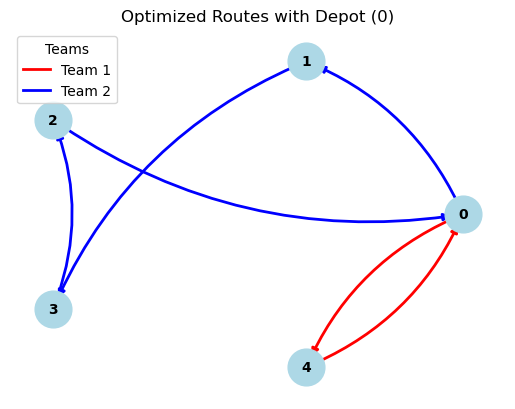


*** Procesando archivo: ./matrix_cost/cost_matrix_15_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 2 equipos...

Problem: 
- Name: unknown
  Lower bound: 37.0
  Upper bound: 37.0
  Number of objectives: 1
  Number of constraints: 440
  Number of variables: 478
  Number of nonzeros: 2354
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1687
      Number of created subproblems: 1687
  Error rc: 0
  Time: 1.0685369968414307
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 6), (6, 0)]
Team 2: [(0, 11), (1, 7), (2, 5), (3, 14), (4, 12), (5, 8), (7, 9), (8, 0), (9, 10), (10, 4), (11, 1), (12, 3), (13, 2), (14, 13)]


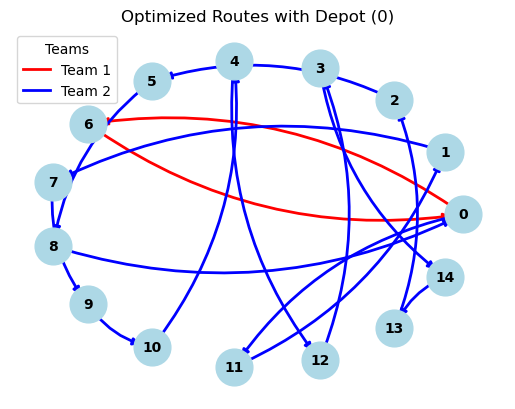


*** Procesando archivo: ./matrix_cost/cost_matrix_10_nodes_1.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 2 equipos...

Problem: 
- Name: unknown
  Lower bound: 16.0
  Upper bound: 16.0
  Number of objectives: 1
  Number of constraints: 195
  Number of variables: 218
  Number of nonzeros: 974
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 59
      Number of created subproblems: 59
  Error rc: 0
  Time: 0.02544379234313965
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 2), (2, 0)]
Team 2: [(0, 5), (1, 7), (3, 1), (4, 6), (5, 9), (6, 3), (7, 8), (8, 0), (9, 4)]


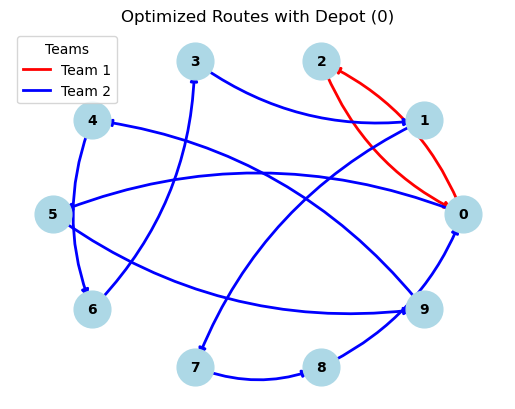

In [8]:
run_multi_tsp("./matrix_cost", [2])


*** Procesando archivo: ./matrix_cost/cost_matrix_20_nodes_0.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 3 equipos...

Problem: 
- Name: unknown
  Lower bound: 7.0
  Upper bound: 7.0
  Number of objectives: 1
  Number of constraints: 1168
  Number of variables: 1257
  Number of nonzeros: 6501
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 115327
      Number of created subproblems: 115327
  Error rc: 0
  Time: 248.54720401763916
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 2), (1, 15), (2, 14), (3, 0), (4, 12), (5, 10), (6, 16), (7, 1), (10, 6), (11, 7), (12, 19), (13, 4), (14, 17), (15, 3), (16, 18), (17, 13), (18, 11), (19, 5)]
Team 2: [(0, 8), (8, 0)]
Team 3: [(0, 9), (9, 0)]


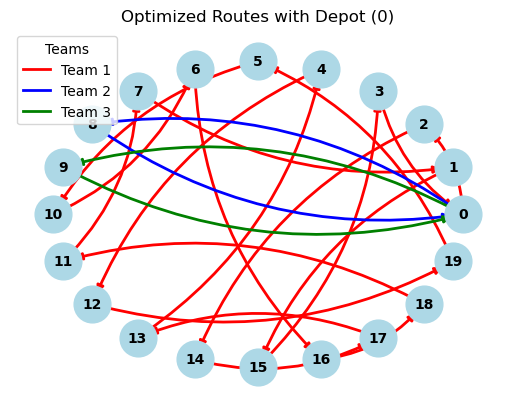


*** Procesando archivo: ./matrix_cost/cost_matrix_5_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 3 equipos...

Problem: 
- Name: unknown
  Lower bound: 21.0
  Upper bound: 21.0
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 87
  Number of nonzeros: 291
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 3
      Number of created subproblems: 3
  Error rc: 0
  Time: 0.004751682281494141
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 2), (2, 0)]
Team 2: [(0, 1), (1, 3), (3, 0)]
Team 3: [(0, 4), (4, 0)]


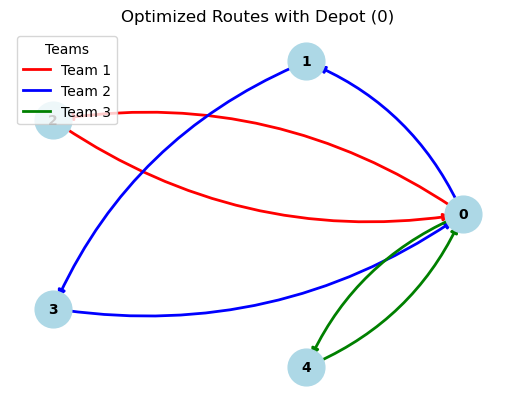


*** Procesando archivo: ./matrix_cost/cost_matrix_15_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 3 equipos...

Problem: 
- Name: unknown
  Lower bound: 39.0
  Upper bound: 39.0
  Number of objectives: 1
  Number of constraints: 653
  Number of variables: 717
  Number of nonzeros: 3531
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1369
      Number of created subproblems: 1369
  Error rc: 0
  Time: 1.463658094406128
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 6), (6, 0)]
Team 2: [(0, 8), (8, 0)]
Team 3: [(0, 11), (1, 10), (2, 5), (3, 12), (4, 2), (5, 0), (7, 14), (9, 7), (10, 9), (11, 1), (12, 4), (13, 3), (14, 13)]


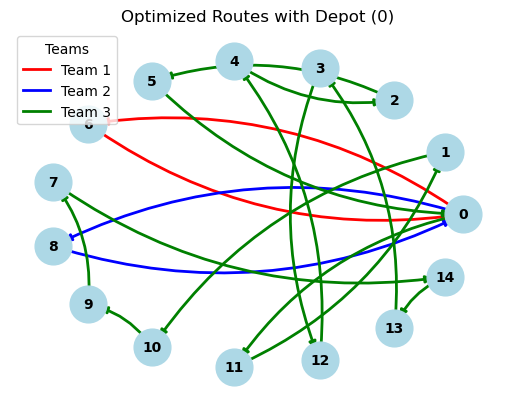


*** Procesando archivo: ./matrix_cost/cost_matrix_10_nodes_1.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 3 equipos...

Problem: 
- Name: unknown
  Lower bound: 19.0
  Upper bound: 19.0
  Number of objectives: 1
  Number of constraints: 288
  Number of variables: 327
  Number of nonzeros: 1461
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 523
      Number of created subproblems: 523
  Error rc: 0
  Time: 0.20408058166503906
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 5), (1, 7), (3, 1), (4, 6), (5, 9), (6, 3), (7, 0), (9, 4)]
Team 2: [(0, 8), (8, 0)]
Team 3: [(0, 2), (2, 0)]


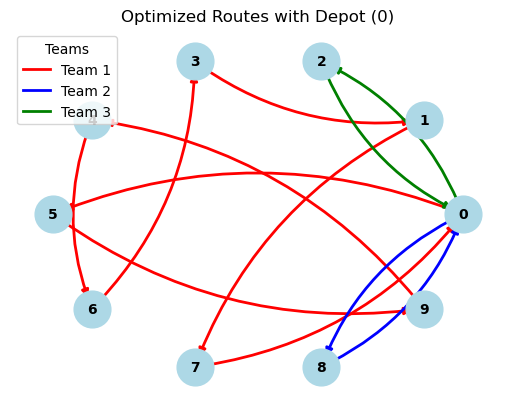

In [9]:
run_multi_tsp("./matrix_cost", [3])


## Conclusion y comparacion